In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

import statsmodels.regression.linear_model as lm

### Load Data and Engineer Features

In [7]:
data_directory = "data/"
df = pd.read_csv(data_directory + "conspiracy_theories_data_orig.csv")
verbose = False
# Only NaN values are in "major" column, so no other cleaning is necessary to remove NaN values
# Benefit of working with survey data as opposed to data collected using messier methods

# Measure for General Conspiracy Belief. Normalized average of responses to questions 1-15 of survey
df['GCB'] = df[['Q'+str(i) for i in range(1, 16)]].mean(axis=1) / 5

# Score how many vocab questions the respondent answered correctly. 0 is correct for VCL 6, 9, 12, and 1 is correct for all others.
df['vocabulary_knowledge'] = pd.concat((df[['VCL' + str(i) for i in [1, 2, 3, 4, 5, 7, 8, 10, 11, 13, 14, 15, 16]]], 
                                        (1 - df[['VCL' + str(i) for i in [6,9,12]]])), axis=1).mean(axis=1)

# The survey asked participants what words they knew. Columns VCL6, VCL9, VCL12 were not real words, and were included in 
# order to perform a validity check
df['vocabulary_misclassification'] = df[['VCL6', 'VCL9', 'VCL12']].mean(axis=1)

# Split up every instance of "major" to a category: HUM (Humanities), BUS (business/law), ART, STEM, and OTHER. 
# This block creates a one-hot encoding for each of these.
names = ["STEM", "HUM", "BUS", "OTHER", "ART"]
for name in names:
    # For each category, there is a file of strings of majors that should be classified as that category
    # Read in the corresponding file
    tf = open(data_directory + f"{name}.txt", "r",newline='\n')
    # Grab all the strings in the file
    majors = [i[:-2] for i in tf.readlines()]
    def func(x): # If string is in the list of majors, return a 1, else a 0
        return int(x in majors)
    func = np.vectorize(func)
    df[name] = 1 
    df[name] = df.major.apply(func) # Create  a new column with the one hot encoding for the given category

#### Defining Edit Distance (from internet)

In [8]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1
    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

#### Categorizing Unknown Majors

In [9]:
#select unassigned
unassigned = df[df["STEM"]+df["HUM"]+df["BUS"]+df["OTHER"]+df["ART"] == 0]
categories = ["STEM", "HUM", "BUS", "OTHER", "ART"]
score = dict()
for index,unknown_string in zip(unassigned.index,unassigned['major']):
    for category in categories:
        tf = open(f"data/{category}.txt", "r",newline='\n')
        majors = [i[:-2] for i in tf.readlines()]
        score[category] = min([levenshteinDistance(str(maj),str(unknown_string)) for maj in majors])
    min_key = min(score, key=score.get)
    df.loc[index,min_key] = 1

In [10]:
# One hot encode the other categorical features
categorical_columns = ['education','urban', 'gender', 'engnat', 'hand', 'religion', 'orientation','race', 'voted', 'married']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
df["constant"] = 1

# Engineer some features about the time taken on the survey for reviewing edge cases (not to be used in regression).
df["total_time_taken_(mins)"] = (df["introelapse"] + df["testelapse"] + df["surveyelapse"])/60
df["total_survey_time_taken_(mins)"] = (df["testelapse"] + df["surveyelapse"])/60

### Review Edge Cases 

In [11]:
print("# Surveys that took over an hour to take (including landing pad time)")
print(sum(df["total_time_taken_(mins)"] >= 60))

print("# Surveys that took over an hour to take (excluding landing pad time)")
print(sum(df["total_survey_time_taken_(mins)"] >= 60))

print("# Surveys that spent over an hour on the landing pad")
print(sum(df["introelapse"]/60 >= 60))

if verbose: 
    df["total_time_taken_(mins)"][df["total_time_taken_(mins)"] < 60].hist()
    plt.subplots()
    df["total_survey_time_taken_(mins)"][df["total_survey_time_taken_(mins)"] < 60].hist()
    plt.subplots()
    df["introelapse"][df["introelapse"] < 60].hist()

# Even though these surveys took a lot longer than seems reasonable, there are no clear indications in the 
# subjects' answers that any of these responses should be dropped. 

# Surveys that took over an hour to take (including landing pad time)
64
# Surveys that took over an hour to take (excluding landing pad time)
20
# Surveys that spent over an hour on the landing pad
44


In [12]:
if verbose: 
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(df[df["introelapse"]/60 >= 60])

In [13]:
# Looking at the 50 fastest responses
if verbose:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df.sort_values(by="total_time_taken_(mins)")[:50])
    
# Again, none of these look responses have any obvious indications that they should be dropped

In [14]:
# Did any respondents put the same thing for each question in the GCB inventory? 
print("# Rows with matching entries in columsn Q1, Q2, ..., Q15")
print(sum(df[["Q" + str(i) for i in range(1, 16)]].apply(lambda x: min(x) == max(x), 1)))
if verbose:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df[df[["Q" + str(i) for i in range(1, 16)]].apply(lambda x: min(x) == max(x), 1)])


# Rows with matching entries in columsn Q1, Q2, ..., Q15
98


### Analysis and Regression

In [15]:
# Drop all the columns that are used for feature engineering and cleaning.
df.drop(columns=['Q'+str(i) for i in range(1, 16)], inplace=True) # Drop the specific question information from which GCB is computed
df.drop(columns=['E'+str(i) for i in range(1, 16)], inplace=True) # Timing information
df.drop(columns=['VCL'+str(i) for i in range(1, 17)], inplace=True) # Specific vocabulary questions, rolled into 
df.drop(columns=['total_time_taken_(mins)', 'total_survey_time_taken_(mins)', 
                 'introelapse', 'surveyelapse', 'testelapse'], inplace=True)
df.drop(columns=['major'], inplace=True)

In [16]:
y = df['GCB']
X = df.drop(columns=['GCB'])

In [17]:
# Statsmodels
###### Run a L1-regularization to see which features we should keep and what we can get rid of #######

# lamb_list = np.geomspace(10**-10, 10**5, 16)

# # # Go through each lambda
# #for lamb in lamb_list:
# model = lm.OLS(y, X).fit_regularized(alpha=1e-3, L1_wt=1)
# beta = model.params
# nonzero = np.abs(beta) > 0.01
# zero = ~nonzero
# # X = X[X.columns[zero.values]]
# X = X[X.columns[nonzero.values]]

model = lm.OLS(y, X).fit()
# print(model.summary().as_latex())
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    GCB   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     9.108
Date:                Tue, 30 Nov 2021   Prob (F-statistic):           2.08e-71
Time:                        21:34:23   Log-Likelihood:                 649.22
No. Observations:                2495   AIC:                            -1174.
Df Residuals:                    2433   BIC:                            -813.5
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
TIPI1           

In [18]:
# Minimize R^2 with regularization
y = df['GCB']
X = df.drop(columns=['GCB'])
# Elasticnet Regularization with Gridsearch (L1, L2)
parameters = {
              'alpha': [10**(-k) for k in range(1,6)],
              'l1_ratio': np.linspace(.4,.6,20)
}

reg = ElasticNet()
clf = GridSearchCV(reg, parameters, n_jobs=-1)
clf.fit(X, y)
print(clf.score(X,y))
clf.best_params_

0.1811793014442713


{'alpha': 0.001, 'l1_ratio': 0.4842105263157895}

In [19]:
# Minimize MSE with regularization
y = df['GCB']
X = df.drop(columns=['GCB'])
# Elasticnet Regularization with Gridsearch (L1, L2)
parameters = {
              'alpha': [10**(-k) for k in range(1,6)],
              'l1_ratio': np.linspace(0.4,0.6,20)
}

reg = ElasticNet()
clf = GridSearchCV(reg, parameters, n_jobs=-1, scoring='neg_mean_absolute_error')
clf.fit(X, y)
print(clf.score(X,y))
clf.best_params_

-0.153970587319955


{'alpha': 0.001, 'l1_ratio': 0.4736842105263158}

In [20]:
# Random Forest Regressor with Gridsearch
parameters = {
    'n_estimators': [100,200],
    'max_depth': list(range(1,6)) + [10],
    'min_samples_leaf': range(1,6),
}

rf = RandomForestRegressor()
clf = GridSearchCV(rf, parameters, n_jobs=-1)
clf.fit(X,y)
print(clf.score(X,y))
clf.best_params_

0.61031132582539


{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}

In [21]:
# Random Forest Regressor with Gridsearch
parameters = {
    'n_estimators': [100,200],
    'max_depth': list(range(1,6)),
    'min_samples_leaf': range(1,6),
}

rf = RandomForestRegressor()
clf = GridSearchCV(rf, parameters, n_jobs=-1)
clf.fit(X,y)
print(clf.score(X,y))
clf.best_params_

0.2306760136582343


{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}

In [22]:
# Random Forest Regressor with Gridsearch
parameters = {
    'n_estimators': [100,200],
    'max_depth': list(range(1,6)),
    'min_samples_leaf': range(4,7),
}

rf = RandomForestRegressor()
clf = GridSearchCV(rf, parameters, n_jobs=-1)
clf.fit(X,y)
print(clf.score(X,y))
clf.best_params_

0.2330434633782532


{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}

In [23]:
importances = clf.best_estimator_.feature_importances_
order = np.argsort(importances)
np.vstack((importances[order], X.columns.values[order]))

array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0001101096241745214,
        0.00011456240414530726, 0.0002790071581801582,
        0.00028127897943534407, 0.0004946743869203023,
        0.0007490892587975068, 0.0009206563685111317,
        0.0010731168923109051, 0.0010955760409600641,
        0.001117014670285802, 0.0013256006290913783,
        0.0015594235255835269, 0.0016863493766806946,
        0.0017020081194202832, 0.0018702774812583292,
        0.001908975462692908, 0.0019961014369810877,
        0.002068547291511306, 0.0021876009401983563,
        0.002325391885984639, 0.0024059532676042536,
        0.002616288213039649, 0.002746412481292286, 0.00303297673871512,
        0.003045300478935367, 0.0030830464410309404,
        0.0032426530606388198, 0.0036149526566690788,
        0.004102726991860787, 0.004633635701165733,
        0.0046578176502726715, 0.004865173425888593,
        0.005166654370913876, 0.0066679200774914914,
        0.006743676499177749, 0.007735943894663154, 0.00931057513801

In [24]:
# Elasticnet Regularization with Gridsearch (L1, L2)
parameters = {
              'alpha': [10**(-k) for k in range(1,6)],
              'l1_ratio': [k/10 for k in range(1,10)]
#               'l1_ratio': [0,1]
}

reg = ElasticNet()
clf = GridSearchCV(reg, parameters, n_jobs=-1)
clf.fit(X, y)
clf.score(X,y)

0.18098906546196503

### Creating Age, Vocab, GCB Heatmap

Text(0.5, 1.0, 'General Conspiracy Belief')

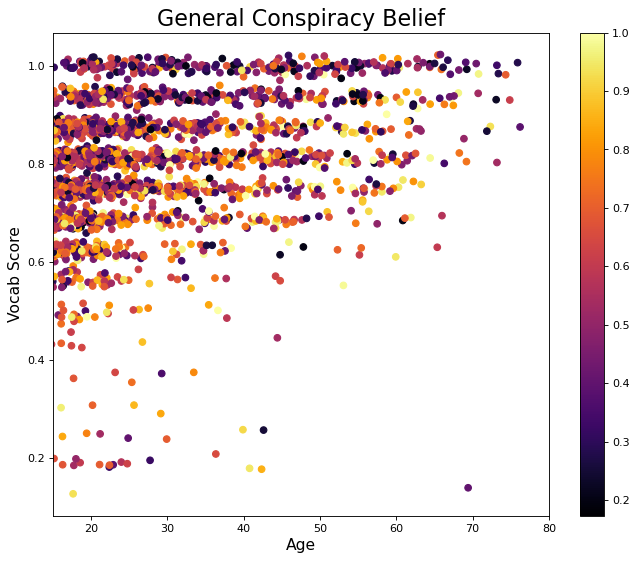

In [25]:
plt.figure(figsize=(10, 8), dpi=80)
noise = np.random.normal(0, .5, df['age'].shape)
perturbed_age = df['age'] + noise
noise2 = np.random.normal(0, .01, df['vocabulary_knowledge'].shape)
perturbed_vocab = df['vocabulary_knowledge'] + noise2
plt.scatter(perturbed_age, perturbed_vocab, s=35, c=df['GCB'], cmap='inferno')
plt.colorbar()
plt.ylabel('Vocab Score',fontsize=14)
plt.xlabel('Age',fontsize=14)
plt.xlim(15,80)
plt.title('General Conspiracy Belief',fontsize=20)